In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)
!pip3 install lightgbm
import lightgbm as lgb

# reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.8 MB/s eta 0:00:00a 0:00:01


# Load Preprocessed Data

In [3]:
POSSIBLE_DIRS = [
    "from_kaggle/cleaned_data",
    "/kaggle/working",
    "/kaggle/input",
]

def find_clean_paths():
    for d in POSSIBLE_DIRS:
        train_candidate = os.path.join(d, "train_clean.csv")
        test_candidate = os.path.join(d, "test_clean.csv")
        if os.path.exists(train_candidate) and os.path.exists(test_candidate):
            return train_candidate, test_candidate
    raise FileNotFoundError("Could not find train_clean.csv and test_clean.csv in known locations.")

train_clean_path, test_clean_path = find_clean_paths()
print("Train clean path:", train_clean_path)
print("Test clean  path:", test_clean_path)

train_df = pd.read_csv(train_clean_path)
test_df = pd.read_csv(test_clean_path)

print("Train_clean shape:", train_df.shape)
print("Test_clean shape :", test_df.shape)
train_df.head()


Train clean path: from_kaggle/cleaned_data/train_clean.csv
Test clean  path: from_kaggle/cleaned_data/test_clean.csv
Train_clean shape: (8693, 50041)
Test_clean shape : (4277, 50040)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerNumber,CabinNum,TotalSpend,...,Surname_Wooterston,Surname_Workmans,Surname_Workmanson,Surname_Wrempeedly,Surname_Wriggins,Surname_Wynneyerson,Surname_Yanton,Surname_Yatters,Surname_Yorkland,Surname_Youngrayes
0,0.720932,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0.0,-0.490655,-1.181321,-0.510541,...,0,0,0,0,0,0,0,0,0,0
1,-0.332557,-0.170439,-0.276082,-0.249566,0.221040,-0.219449,1.0,-0.490655,-1.181321,-0.248363,...,0,0,0,0,0,0,0,0,0,0
2,2.055350,-0.273285,1.998823,-0.292365,5.732776,-0.215170,0.0,-0.490655,-1.181321,3.188082,...,0,0,0,0,0,0,0,0,0,0
3,0.299536,-0.340290,0.536429,0.342766,2.706059,-0.091947,0.0,0.468615,-1.181321,1.333249,...,0,0,0,0,0,0,0,0,0,0
4,-0.894417,0.131863,-0.237179,-0.033861,0.235342,-0.255389,1.0,-0.490655,-1.179351,-0.121906,...,0,0,0,0,0,0,0,0,0,0


# Prepare Features and Target

In [4]:
target_col = "Transported"

if train_df[target_col].dtype == bool:
    train_df[target_col] = train_df[target_col].astype(int)
elif train_df[target_col].dtype == object:
    mapping = {"True": 1, "False": 0, "true": 1, "false": 0}
    train_df[target_col] = train_df[target_col].map(mapping).astype(int)
else:
    train_df[target_col] = train_df[target_col].astype(int)

feature_cols = [c for c in train_df.columns if c != target_col]
print("Number of features:", len(feature_cols))

X = train_df[feature_cols].values
y = train_df[target_col].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape


Number of features: 50040


((6954, 50040), (1739, 50040))

# Helper Functions

In [5]:
def plot_confusion_matrix(cm, class_names=("Not Transported", "Transported"), title="Confusion Matrix"):
    plt.figure(figsize=(4, 4))
    im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


# Single Train/Validation LightGBM Model

In [9]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 20,
    "verbosity": -1,
    "seed": 42,
}

evals_result = {}

callbacks = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=50),
    lgb.record_evaluation(evals_result),
]

model_single = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, val_data],
    valid_names=["train", "valid"],
    callbacks=callbacks,
)

print("Best iteration:", model_single.best_iteration)

Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.371697	valid's binary_logloss: 0.396194
[100]	train's binary_logloss: 0.317535	valid's binary_logloss: 0.369294
[150]	train's binary_logloss: 0.283681	valid's binary_logloss: 0.363464
[200]	train's binary_logloss: 0.257887	valid's binary_logloss: 0.361584
[250]	train's binary_logloss: 0.236084	valid's binary_logloss: 0.362664
Early stopping, best iteration is:
[199]	train's binary_logloss: 0.258257	valid's binary_logloss: 0.361534
Best iteration: 199


## Training Curves

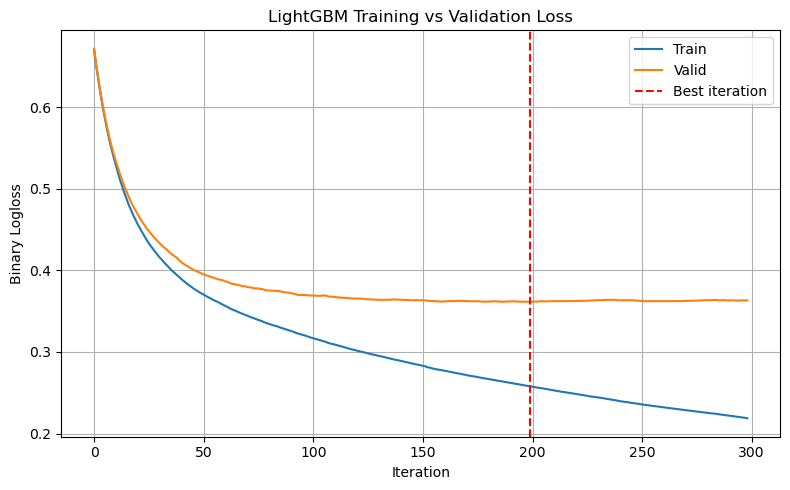

In [10]:
train_loss = evals_result["train"]["binary_logloss"]
val_loss = evals_result["valid"]["binary_logloss"]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Valid")
plt.axvline(model_single.best_iteration, color="red", linestyle="--", label="Best iteration")
plt.xlabel("Iteration")
plt.ylabel("Binary Logloss")
plt.title("LightGBM Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


## Evaluation on Validation Set

Confusion matrix:
 [[700 163]
 [156 720]]

Classification report:
               precision    recall  f1-score   support

           0     0.8178    0.8111    0.8144       863
           1     0.8154    0.8219    0.8186       876

    accuracy                         0.8166      1739
   macro avg     0.8166    0.8165    0.8165      1739
weighted avg     0.8166    0.8166    0.8166      1739



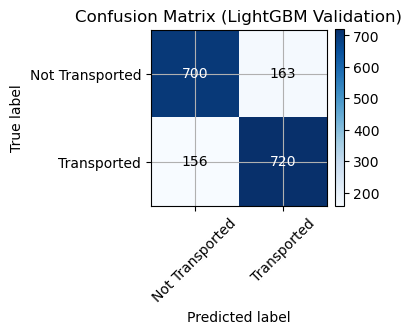

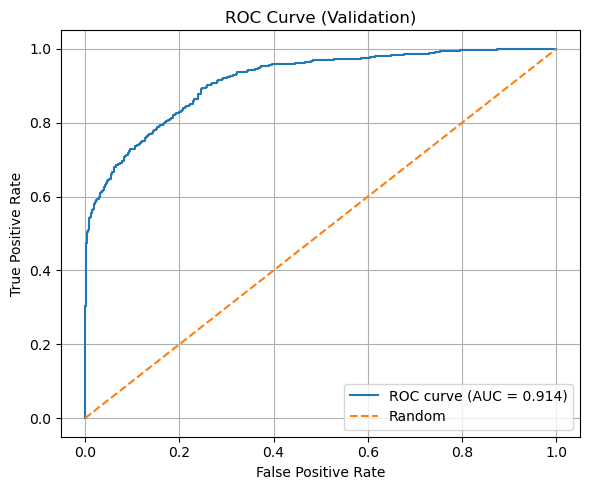

In [11]:
# predict probabilities and labels
val_probs = model_single.predict(X_val, num_iteration=model_single.best_iteration)

# default threshold 0.5
val_preds = (val_probs >= 0.5).astype(int)

cm = confusion_matrix(y_val, val_preds)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_val, val_preds, digits=4))

plot_confusion_matrix(cm, title="Confusion Matrix (LightGBM Validation)")

fpr, tpr, _ = roc_curve(y_val, val_probs)
auc = roc_auc_score(y_val, val_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Feature Importance

In [12]:
importances = model_single.feature_importance(importance_type="gain")
feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(20)


,feature,importance
8,TotalSpend,12718.623078
7,CabinNum,4692.528897
10,FoodCourt_log,2923.335902
12998,CryoSleep_False,2855.941444
0,Age,2474.865969
12995,HomePlanet_Earth,2344.720407
4,Spa,2305.117953
14,TotalSpend_log,2280.817817
5,VRDeck,2042.780771
13,VRDeck_log,1828.477356


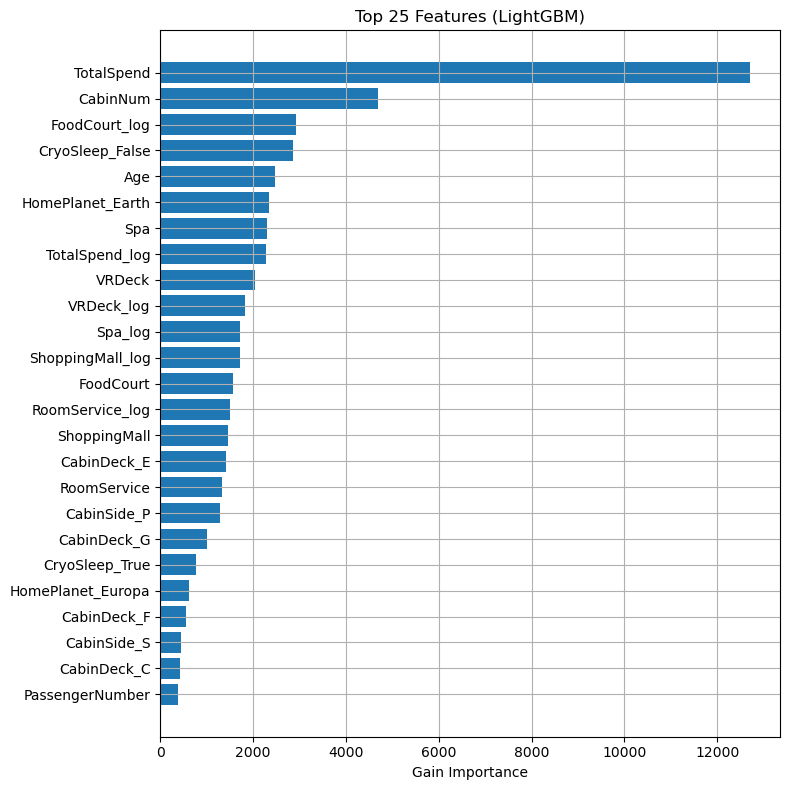

In [13]:
top_n = 25
plt.figure(figsize=(8, 8))
plt.barh(feat_imp["feature"].head(top_n)[::-1], feat_imp["importance"].head(top_n)[::-1])
plt.xlabel("Gain Importance")
plt.title(f"Top {top_n} Features (LightGBM)")
plt.tight_layout()
plt.show()


# 5-Fold Cross-Validation

In [15]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_aucs = []
fold_accs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n=== Fold {fold} ===")
    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain)

    evals_result_cv = {}

    callbacks_cv = [
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=200),
        lgb.record_evaluation(evals_result_cv),
    ]

    model_cv = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dvalid],
        valid_names=["train", "valid"],
        callbacks=callbacks_cv,
    )

    va_probs = model_cv.predict(X_va, num_iteration=model_cv.best_iteration)
    va_preds = (va_probs >= 0.5).astype(int)

    auc = roc_auc_score(y_va, va_probs)
    acc = (va_preds == y_va).mean()
    fold_aucs.append(auc)
    fold_accs.append(acc)

    print(f"Fold {fold} AUC: {auc:.4f}, ACC: {acc:.4f}")

print("\nCV AUC mean ± std:", np.mean(fold_aucs), np.std(fold_aucs))
print("CV ACC mean ± std:", np.mean(fold_accs), np.std(fold_accs))



=== Fold 1 ===
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.255099	valid's binary_logloss: 0.375005
Early stopping, best iteration is:
[185]	train's binary_logloss: 0.261689	valid's binary_logloss: 0.373831
Fold 1 AUC: 0.9079, ACC: 0.8148

=== Fold 2 ===
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.251906	valid's binary_logloss: 0.386949
Early stopping, best iteration is:
[159]	train's binary_logloss: 0.27288	valid's binary_logloss: 0.385411
Fold 2 AUC: 0.9017, ACC: 0.8079

=== Fold 3 ===
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.25359	valid's binary_logloss: 0.375635
Early stopping, best iteration is:
[195]	train's binary_logloss: 0.256067	valid's binary_logloss: 0.374936
Fold 3 AUC: 0.9074, ACC: 0.8131

=== Fold 4 ===
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.255543	valid's binary_log

# Test Predictions and Submission File

In [19]:
import pandas as pd
import os
import numpy as np

POSSIBLE_DIRS = [
    "from_kaggle",
    "from_kaggle/cleaned_data",
    "/kaggle/working",
    "/kaggle/input",
]

final_num_boost_round = model_single.best_iteration
if final_num_boost_round is None:
    final_num_boost_round = 500 

full_train_data = lgb.Dataset(X, label=y)

model_final = lgb.train(
    params,
    full_train_data,
    num_boost_round=final_num_boost_round,
    valid_sets=[full_train_data],
    valid_names=["train"],
)

X_test = test_df[feature_cols].values
test_probs = model_final.predict(X_test)
test_preds = (test_probs >= 0.5).astype(int)

POSSIBLE_DIRS = [
    "from_kaggle",
    "from_kaggle/cleaned_data",
    "/kaggle/input/spaceship-titanic",
    "/kaggle/input",
    "/mnt/data",
]

def find_original_test_path():
    for d in POSSIBLE_DIRS:
        candidate = os.path.join(d, "test.csv")
        if os.path.exists(candidate):
            return candidate
    raise FileNotFoundError("Could not find original test.csv in known locations.")

orig_test_path = find_original_test_path()
orig_test = pd.read_csv(orig_test_path)

submission = pd.DataFrame({
    "PassengerId": orig_test["PassengerId"].astype(str),
    "Transported": test_preds.astype(bool)
})

# verify column order just to be explicit
submission = submission[["PassengerId", "Transported"]]

submission_path = "lightgbm_submission.csv"
submission.to_csv(submission_path, index=False)
print("Saved submission to:", submission_path)
submission.head()


Saved submission to: lightgbm_submission.csv


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
